In [1]:
import os    
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import *
%matplotlib inline

# this is the size of our encoded representations
encoding_dim = 40 ## 39.60%
#encoding_dim = 80 ## 39.02%
#encoding_dim = 150 ## 38.25%


# this is our input placeholder
input_img = Input(shape=(3072,))

# "encoded" is the encoded representation of the input
encoded = Dense(2560, activation='relu')(input_img)  
encoded = Dense(2048, activation='relu')(encoded)  
encoded = Dense(1536, activation='relu')(encoded)  
encoded = Dense(1024, activation='relu')(encoded)  
encoded = Dense(384, activation='relu')(encoded)  
encoded = Dense(192, activation='relu')(encoded)  
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(3072, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)


In [2]:
print (encoding_dim)
print (input_img)
print (encoded)
print (decoded)
print (autoencoder)

40
input_1
Elemwise{mul,no_inplace}.0
sigmoid.0


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [4]:
print (encoder)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [6]:
print (encoded_input)
print (decoder_layer)
print (decoder)

input_2


In [7]:
#autoencoder.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy') #around 35.47% test accuracy
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #around 40% test accuracy
#autoencoder.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy') #around 10% test accuracy
#autoencoder.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy') #around 10% test accuracy

In [8]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [9]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [10]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, verbose=0)
]
autoencoder.fit(x_train, x_train,
                nb_epoch=320,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)


Train on 50000 samples, validate on 10000 samples
Epoch 1/320
50000/50000 [==============================] - 39s - loss: 11647.8063 - acc: 7.0000e-04 - val_loss: 11701.6916 - val_acc: 8.0000e-04
Epoch 2/320
50000/50000 [==============================] - 39s - loss: 11611.5305 - acc: 0.0016 - val_loss: 11684.6457 - val_acc: 0.0015
Epoch 3/320
50000/50000 [==============================] - 39s - loss: 11599.0981 - acc: 0.0020 - val_loss: 11675.7221 - val_acc: 0.0024
Epoch 4/320
50000/50000 [==============================] - 39s - loss: 11592.1854 - acc: 0.0024 - val_loss: 11670.7037 - val_acc: 0.0025
Epoch 5/320
50000/50000 [==============================] - 39s - loss: 11587.8507 - acc: 0.0024 - val_loss: 11666.8384 - val_acc: 0.0034
Epoch 6/320
50000/50000 [==============================] - 39s - loss: 11584.9220 - acc: 0.0032 - val_loss: 11663.9404 - val_acc: 0.0033
Epoch 7/320
50000/50000 [==============================] - 39s - loss: 11582.0430 - acc: 0.0032 - val_loss: 11661.7279 -

In [12]:
print (autoencoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2560)          7866880     input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2048)          5244928     dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1536)          3147264     dense_2[0][0]                    
___________________________________________________________________________________________

In [13]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2560)          7866880     input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2048)          5244928     dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1536)          3147264     dense_2[0][0]                    
___________________________________________________________________________________________

In [14]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
print (encoded_imgs.size)
print (encoded_imgs.shape)
print (encoded_imgs.nbytes)


decoded_imgs = decoder.predict(encoded_imgs)
print (decoded_imgs.size)
print (decoded_imgs.shape)
print (decoded_imgs.nbytes)

400000
(10000, 40)
3200000
30720000
(10000, 3072)
245760000


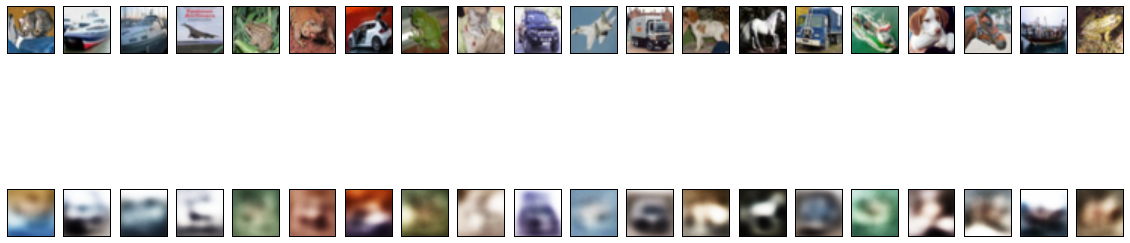

In [15]:
import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
#Predict the digits using a classifier
#Use the reduce Encoded train and test images
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)


2000000
(50000, 40)
16000000


In [17]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(encoded_train_imgs, y_train)

In [19]:
y_pred = clf.predict(encoded_test_imgs)


In [20]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  3471 wrong:  6529 error rate:  65.29 %
got correctly  34.71 %
